
#### Preparing data
Run the next cells to download and prepare the datasets and util functions.


In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [3]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

--2020-04-28 01:59:40--  https://docs.google.com/uc?export=download&confirm=H01A&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf
Resolving docs.google.com (docs.google.com)... 172.217.203.100, 172.217.203.139, 172.217.203.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-08-docs.googleusercontent.com/docs/securesc/phjq5epdapqihcg1q8pd3gejn761f96n/5a8htdu629ss0kr1l703378o2p0qpn1e/1588039125000/02012202667471862451/17968226054316618721Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download [following]
--2020-04-28 01:59:40--  https://doc-0s-08-docs.googleusercontent.com/docs/securesc/phjq5epdapqihcg1q8pd3gejn761f96n/5a8htdu629ss0kr1l703378o2p0qpn1e/1588039125000/02012202667471862451/17968226054316618721Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download
Resolving doc-0s-08-docs.googleusercontent.com (doc-0s-08-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connect

In [0]:
if download_data:
    unzip_leaf_dataset()

Notebook start

In [5]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.2.0-rc3'

In [0]:
import os
import random
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as plt

import local.lib as lib
from init import dataset_dir

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [0]:
data_dir = "./local/datasets/"

### Read data from the CSV file

In [11]:
#here we split the data
split=0.7
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


### Target onehot 

In [0]:
y_train_oh = np.eye(99)[y_train]#num_classes
y_test_oh  = np.eye(num_classes)[y_test]

In [0]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [14]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [15]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128), (297, 99))

In [0]:
x_trainif = np.r_[[i.flatten() for i in X_train_ri]]
x_testif  = np.r_[[i.flatten() for i in X_test_ri]]

In [17]:
x_trainif.shape, x_testif.shape

((693, 16384), (297, 16384))

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde


### Set up a model with Keras and train 

In [0]:

class MyModel(Model):
    def __init__(self, bn1=False, bn2=False):
        super(MyModel, self).__init__()
        self.bn1 = bn1
        self.bn2 = bn2
            
    def build(self, input_shape):
        
        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)    
        
        self.w2 = self.add_weight(shape=(100, 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)
        
        self.w3 = self.add_weight(shape=(100,99 ), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b3 = self.add_weight(shape=(99, ), initializer='random_normal', trainable=True, dtype=tf.float32)        

        
    @tf.function
    def get_z1(self, X):
        return tf.matmul(X,self.w1)+self.b1
                
    @tf.function
    def get_z2(self, X):
        z1 = self.get_z1(X)
        a1 = relu(z1)
        return tf.matmul(a1,self.w2)+self.b2
    
    @tf.function
    def get_z3(self, X):
        z2 = self.get_z2(X)
        a2 = relu(z2)
        return tf.matmul(a2,self.w3)+self.b3
        
    @tf.function
    def call(self, X):
        z3 = self.get_z3(X)
        a3 = softmax(z3)        
        return a3
        
    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1 = []
        self.hz2 = []
        self.hz3 = []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.hz3.append(self.get_z3(X_batch).numpy().flatten())
                self.hloss.append(loss_value)
    
    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)    
    
    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005, 
                         color=plt.cm.RdBu(255*i/len(s)), 
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(132)
        plot_z_history(self.hz1); plt.title("z1 (before activation function at layer 1)\nred signals the first epoch")
        plt.subplot(133)
        plot_z_history(self.hz3); plt.title("z2 (before activation function at layer 2)\nred signals the first epoch")

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy


100% (10 of 10) |########################| Elapsed Time: 0:00:06 Time:  0:00:06
 25% (10 of 40) |######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

train accuracy 0.040
test  accuracy 0.034


100% (40 of 40) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (40 of 40) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


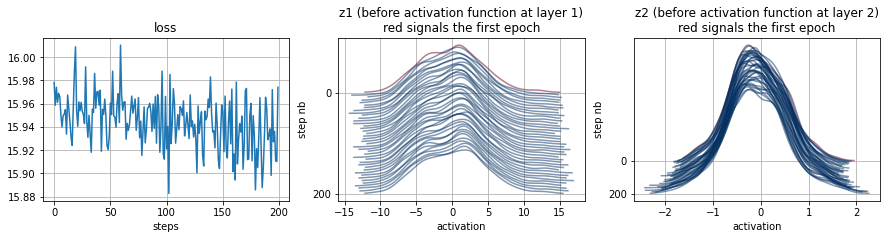

In [30]:
#instantiate the model
#sgd = SGD(lr=0.01, nesterov=True, decay=1e-3, momentum=0.9)
model = MyModel()
model.compile(optimizer= 'SGD', loss=categorical_crossentropy)
model.fit(x_trainif.astype(np.float32), np.eye(99)[y_train.astype(int)], epochs=10, batch_size=36)#x_train flatten and 
predict = lambda X: (model.predict(X)[:,0]>0.5).astype(int)
print ("train accuracy %.3f"%model.score(x_trainif, y_train))
print ("test  accuracy %.3f"%model.score(x_testif, y_test))
model.plot_hist()
#model.summary()

100% (20 of 20) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
  6% (5 of 80) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

train accuracy 0.045
test  accuracy 0.047


100% (80 of 80) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (80 of 80) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


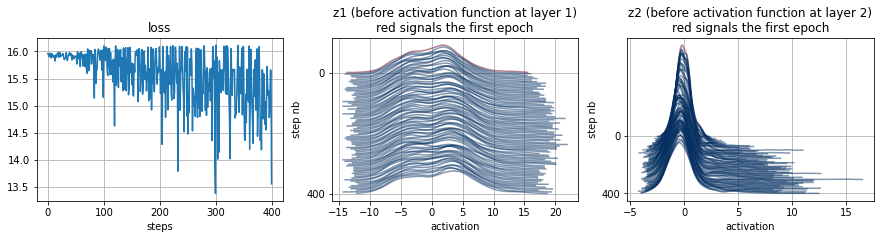

In [31]:
model.fit(x_trainif.astype(np.float32), np.eye(99)[y_train.astype(int)], epochs=20, batch_size=36)#x_train flatten and 
predict = lambda X: (model.predict(X)[:,0]>0.5).astype(int)
print ("train accuracy %.3f"%model.score(x_trainif, y_train))
print ("test  accuracy %.3f"%model.score(x_testif, y_test))
model.plot_hist()